<a href="https://colab.research.google.com/github/sunidhi-shetty/classical_machine_learning_Forecasting_and_RecSys/blob/main/02-Notes-TimeSeriesAnalysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Content
| Topic | Time |
| - | - |
| Data Preprocessing Recap | 5 mins |
| Smoothing Based Methods | 60 mins |
|Stationarity | 15 mins |
|Autocorrelation and Partial Correlation | 20 mins |
|Correlation vs Causation | 5 mins |
| ARIMA Family | 60 mins |
| **Total** | **2 h 45 mins** |

---


## Preparing the data


Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [ ]:
plt.rcParams['figure.figsize'] = (20,6)

Reading the data from excel format

In [ ]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 18.8MB/s]


In [ ]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [ ]:
# set index as date
mobile_sales.set_index('DATE', inplace=True)

mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


## Data Preprocessing (Recap from last lecture)

Let's do all the data processing we learnt about in the last lecture
- Setting index as date
- Perform linear interpolation
- Taking care of anomalies by clipping values using quantiles
- Plotting the resultant time series

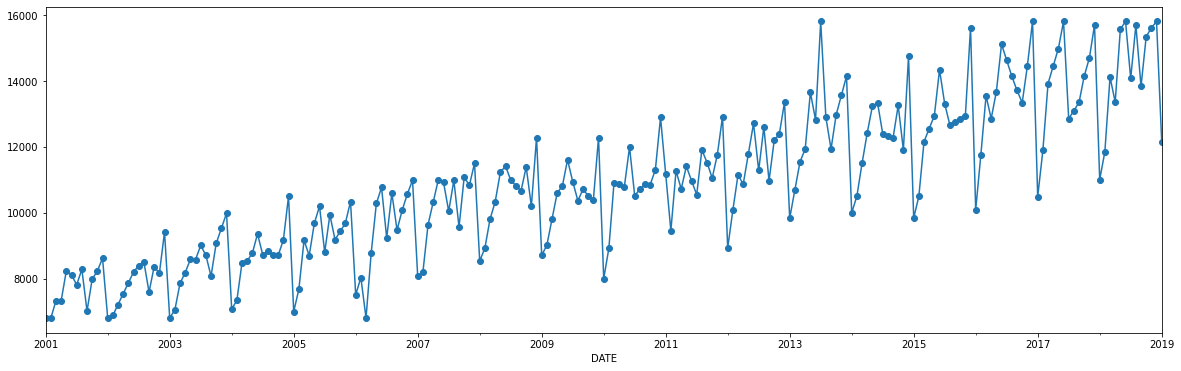

In [ ]:

# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

**Train - test splitting of data**

In [ ]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

test_x

,Sales
DATE,
2018-02-01,11852.0
2018-03-01,14123.0
2018-04-01,13360.0
2018-05-01,15576.0
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0


Also, let's create a function  to estimate the performance of different models

In [ ]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

Recall that in the last lecture, we had not gotten the desired MAPE score using the **simple methods**.

Now that we've performed the required preprocessing on our time series, and even split it into train and test sets, lets look at another family of forecasting techniques, called **smoothing based models**.

---

# Smoothing Based Methods


Let's expand more on the Moving Averages model.
## 1. Moving average forecasting (Implementation)

We saw the illustration of concept of Moving averages using the `rolling()` function.

> **Q. How can we forecast future values using Moving Average concept?**

In order to make our forecast, we want to take the average of last 3 data values.

Let's look at the scratch implementation of the same.

![picture](https://drive.google.com/uc?export=view&id=1pFngGfjJUL-1wV2Gw2gQyfwT87Qa53tN)

Let's make a copy of the series in df, to avoid making changes in the original series.



In [ ]:
import numpy as np

df = mobile_sales.copy()

> **Q. How do we obtain the dates for our future forecasts?**

Since we're working with a time series, naturally, we need to first create new data points with the future dates

As of now we have data till 2019-01-01, but we wish to forecast values for future.

The function **pd.date_range** is used to create the new dates for giving the forecasted values

We need to specify the following parameters in **pd.date_range**:-
- `start`: left bound for generating dates
- `periods`: Number of time steps in the range
- `freq`: frequency aliases, since we need month start frequency, our alias is `MS`. There are many more aliases.

Using the **pd.date_range**, we create a new dataframe that we can append to the existing one.

In [ ]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS'))

""
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01



**Note:**
- Notice that we got the first entry as Jan-2019, which already existed in our series.
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence we utilise slicing by mentioning `[1:]`

In [ ]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')[1:]))

df.tail(20)

,Sales
2018-06-01,15809.4
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0
2018-12-01,15809.4
2019-01-01,12160.0
2019-02-01,NaN
2019-03-01,NaN


> **Q. How can we forecast future values using concept of Moving Averages?**

In order to forecast value for time t=k, we take average value of  the past n points, $x_{t-1}, x_{t-2}, x_{t-3}, ..., x_{t-n}$.

Calculate next point from MA of previous points. Then calculate the 2nd point using 1 previous forcasted point and remaining actual points and so on.

![picture](https://drive.google.com/uc?export=view&id=19cmb7-9VP-Vm7SxE9qEO1KUp6mn1PyZR)

<br>

> **Q. How do we code this?**

First, lets initialise a new variable `pred` to all the sales that are not NaN.

Now we run a loop. Since we wish to predict values for a year, the loop iterates 12 times.

Take the average of last 3 values on every iteration, and append it to the series.




In [ ]:
df.Sales.tail(15)

2018-11-01    15615.0
2018-12-01    15809.4
2019-01-01    12160.0
2019-02-01        NaN
2019-03-01        NaN
2019-04-01        NaN
2019-05-01        NaN
2019-06-01        NaN
2019-07-01        NaN
2019-08-01        NaN
2019-09-01        NaN
2019-10-01        NaN
2019-11-01        NaN
2019-12-01        NaN
2020-01-01        NaN
Name: Sales, dtype: float64

In [ ]:
pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

pred[-20:]

array([15809.4       , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 15809.4       , 12160.        ,
       14528.13333333, 14165.84444444, 13617.99259259, 14103.99012346,
       13962.6090535 , 13894.86392318, 13987.15436671, 13948.20911446,
       13943.40913479, 13959.59087199, 13950.40304041, 13951.13434906])

So, we can see that we have forecasts here, based on average of last 3 points for all new points.

Let's round them.

In [ ]:
pred = pred.round(1)
pred[-20:]

array([15809.4, 14080. , 15697. , 13838. , 15351. , 15615. , 15809.4,
       12160. , 14528.1, 14165.8, 13618. , 14104. , 13962.6, 13894.9,
       13987.2, 13948.2, 13943.4, 13959.6, 13950.4, 13951.1])

Now let's plot this.

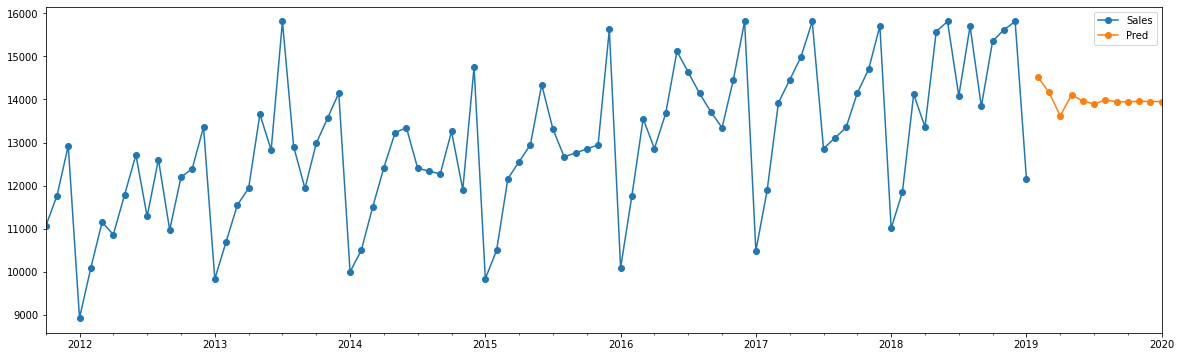

In [ ]:
df['Pred'] = pred

df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(100).plot(style='-o')

> **Q. Does this look like a good forecast?**

These forecasted values are certainly better than forecasting the mean/median or any constant values. At least, the levels looks okay.

However, it can be clearly seen that the forecast is not able to predict the variations and it gives a flat line after few predictions.

<br>

Also, if you think about it, this technique, doesn't seem to using the past data.

What is the point of having data spanning over 18 years, if we're just looking at the last 3 entries to forecast a new value.

> **Q. What would be the performance of the Moving Averages model?**

While we're at it, let's check the performance of Moving Averages model also, by using train and test sets.

MAE : 1692.467
RMSE : 1875.03
MAPE: 0.115


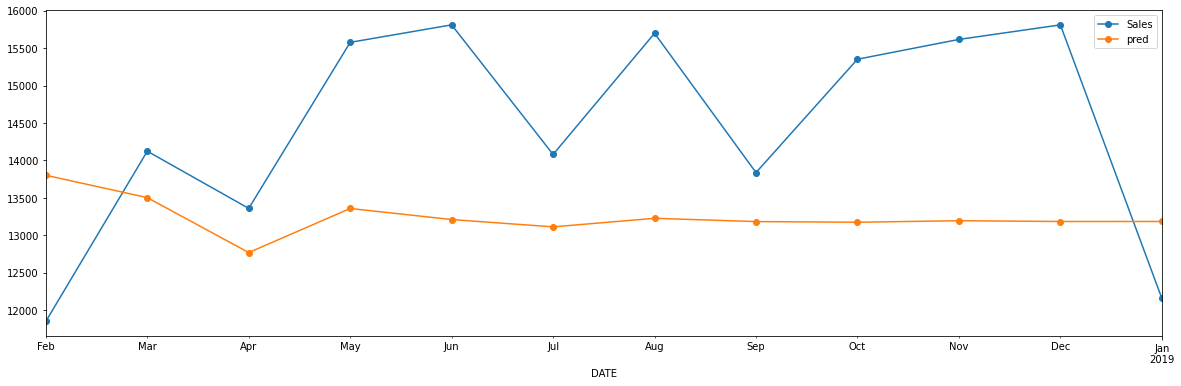

In [ ]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
  pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As per MAPE, we can say that our model has 11.5% error.

This is much better than the other models we saw. Lets look at more models.

## 2. Simple exponential smoothing

In order to avoid the shortcomings of Moving average forecasts, lets look at another forecasting technique, called **Simple exponential technique**.

> **Q. What is the idea behind Simple exponential technique?**

The key idea is that, we want to keep some memory of the entire time series, but also, we want to give more value to the recent most data.

Instead of ignoring the past values completely, let's assign them a small weight.

The major weight would still be assigned to the recent most entry.

This forms a decaying trend.

<br>

> **Q. Why do we need to consider the older data?**

 Let us assume a company was doing good for 10 years, and the sales went down for last 2 years because of **COVID-19** :
* Now if we predict sales, basing on the past few months, the forecast would be very low which is not an optimal prediction
* Hence it is required to consider the past series also to get a better forecast.


![picture](https://drive.google.com/uc?export=view&id=177iuo0YBDxvVoAYOh1pH4dSuTRjcN1V2)

<br>

#### Q. How can this idea be formulated mathematically?
Let's consider the weight we assign to the recent most value be $\alpha$.

$\alpha$ is called the **smoothing parameter**.

So, our forecast at time t becomes,

$ŷ_{t+h} = α*y_{t} + (1-α)*ŷ_{t}$

Here, $h$ is the **horizon**, it can take values such as $h=1, 2, 3, 4, ..$, it depicts the number of steps in future.

<br>

> **Q. We wanted to consider the entire time series, this formulation just has data of 2 points, why?**

This formulation is actually **recursive** in nature.

So, when we write $ŷ_{t-1}$, that gets broken down further as

$ŷ_{t+h} = α * y_{t} + (1-α)* [α* y_{t-1} + (1-α)*ŷ _{t-2}]$

This is further recursed in order to incorporate the entire time series.

<br>

> **Note:-**
- So, the concise form of writing the equation for SES is: $ŷ_{t+1} = αy_{t} + (1-α)ŷ_{t}$
- But if we were to open the expansion, the SES formulation is actually: $ŷ_{t+1} = αy_{t} + α(1-α)y_{t-1} + α(1-α)^2ŷ _{t-2} + ...$
- These are just different ways of writing the same equation; they're equivalent.



![picture](https://drive.google.com/uc?export=view&id=1UruTOKBSFF33-pVQH4_VYPiHHrC4oy8E)

<br>

> **Q. What does the plot of weights look like?**

We give more weightage to the most recent values, and this weightage keeps decreasing for earlier values.

As you can see from the formulation also, weights are exponentially decaying.

This is why. we call this method **Simple Exponential Smoothing**.


![picture](https://drive.google.com/uc?export=view&id=1ewCKPMW-_8CjtP2j5tgcdn_24C5aKaMH)

> **Q. How can we implement this concept in code?**

Let's look into the code for the same.

We have a built-in method for this technique `SimpleExpSmoothing()`, under **statsmodels** library.

While fitting this model, we need to specify the `smoothing_level` parameter, which is the same as $\alpha$ we've been looking at.
- The recommended starting point value for `smoothing_level` is $\frac{1}{2* seasonality}$
- For our case, this becomes $\frac{1}{2*12}$


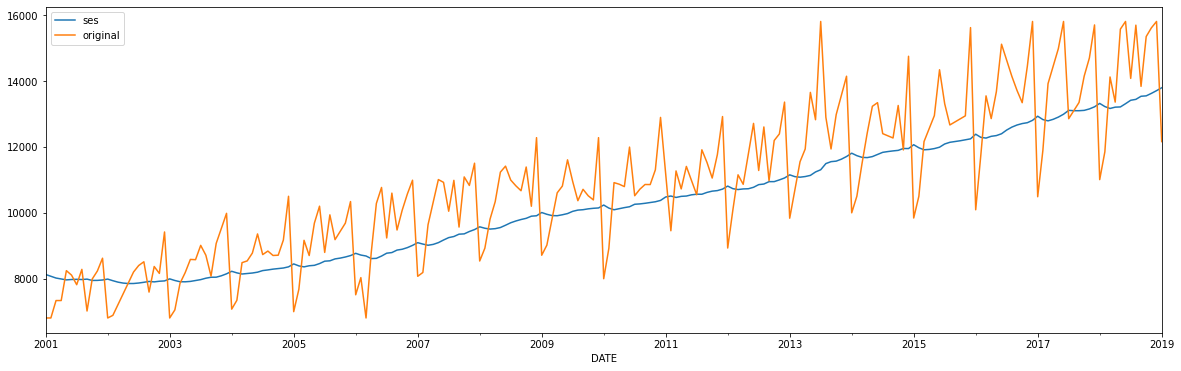

In [ ]:
model = pd.Series(sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12)).fittedvalues)

model.plot(label='ses')
mobile_sales.Sales.plot(label='original')
plt.legend()

From the graph, it looks like the Simple Exponential Smoothing, got the levels right.

> **Q. How is this plot different from Moving Averages plot?**

This looks similar.

But, Unlike moving averages, it **does not have the offset** in beginning and end, because this method is initialised properly.

They fix the previous values as well.

<br>

> **Q. How can we make future forecasts from this method?**

`SimpleExpSmoothing` in statsmodels also have a `forecast()` method.

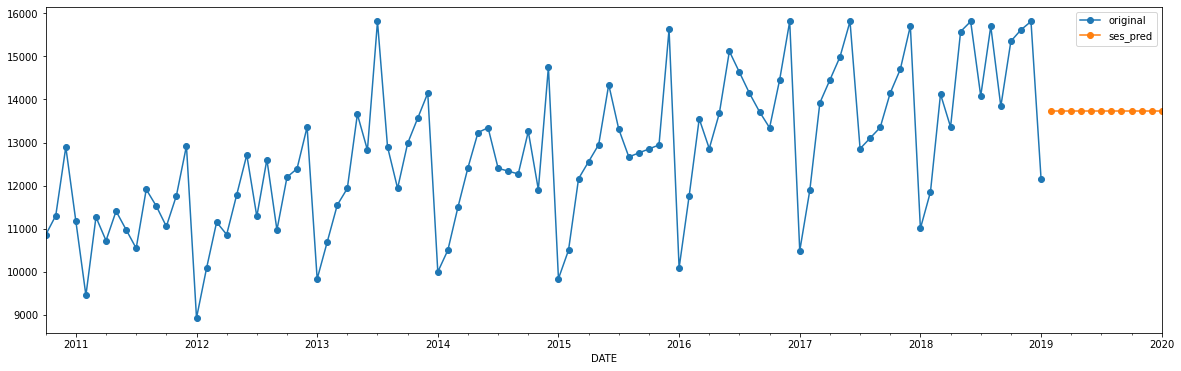

In [ ]:
model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))
pred = model.forecast(steps = 12)

mobile_sales.Sales.tail(100).plot(label='original', style='-o')

pred.plot(label='ses_pred', style='-o')
plt.legend()

> **Q. Is this a good forecast?**

**No.**

In fact, it looks even worse. This is a complete straight line, surely, it can't be a good forecast.

This is because you dont have the previous *actual value* available for horizon > 1. So the current forecast is used for all next values.

But one advantage is that the **level of the forecasted values are right**.

So, we have the right levels, if we can predict the trend and seasonality right, we should get a good forecast.

<br>

Since it captures the correct level, for the forecast, this model would've worked well if:
- Consider our business case: We have data till January
- Suppose we are asked to forecast sales value for next month (February): $\hat{y}_{t+1}$
- Then we wait for Februaryto end, to observe the actual sales value: $y_{t+1}$
- Now, we forecast the value for March: $\hat{y}_{t+2}$
- This way, SES would be able to captue the trend also.

But this is not our business case, we've been asked to forecast values for the next 12 months.

![picture](https://drive.google.com/uc?export=view&id=16imbVgcjvQuwWlmkMjDL-SoHU4RimebP)


<br>


> **Q. What would be the performance of the Simple Exponential model?**

While we're at it, let's check the performance of Simple Exponential model also, by using train and test sets.

MAE : 1621.347
RMSE : 1830.599
MAPE: 0.109


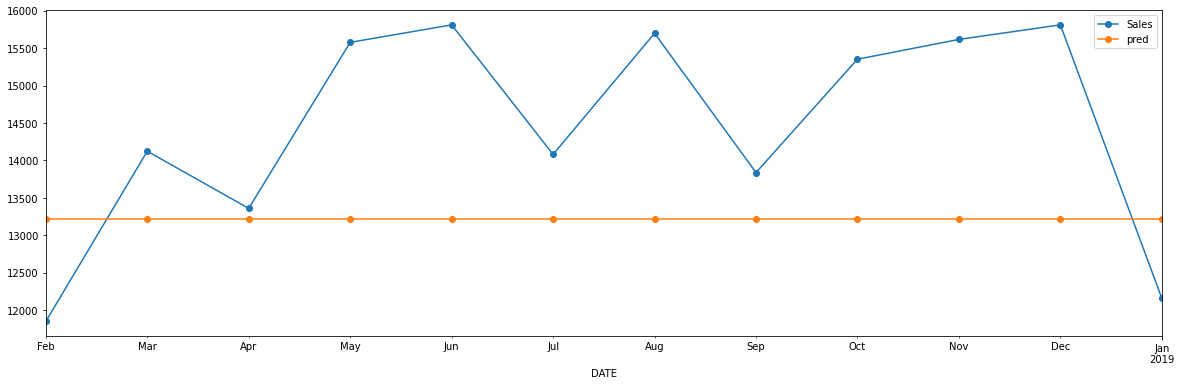

In [ ]:
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As expected, the prediction is a straight line, but the erros is 10% which is less than the error of  moving average.

So this model is performing better.

<br>

The SES Model is missing both
- trend, and
- seasonality




---

##3. Double Exponential smoothing (Holt's method)

We saw the shortcomings of Simple Exponential model
- doesn't capture the trend
- gives one unique value

> **Q. How can we overcome these shortcomings?**

Perhaps if we introduce the trend value to the formulation, we can fix the problem of getting a straight line.

Since we want the trend of entire time series, in order to incorporate them, we will have to provide weights to the trend value also.

Naturally, this will also form a exponentially decaying series.

Hence this is called **Double Exponential smoothing (aka Holt's method)**

<br>

#### Q. How does our formulation change by incorporating trend?

We have to assign weights to the trend values also.

Hence, the formulation becomes

 $ŷ_{t+h} = l_{t} + hb_{t}$

where,
$l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1})$

We call this as the **level** of time series at time t.

**Remember:** This is still a recursive function.


<br>

> **Q. How can we calculate trend value?**

We know from Calculas, that we can calculate **slope** of a curve by the formula
$\frac{Δy}{Δt} = \frac{y_t - y_{t-1}}{Δt}$

For our case, this becomes,
$\frac{Δy}{Δt} = y_t - y_{t-1}$ as $Δt = 1$

This slope value would actually also be equal to the **trend** of the series.

By plugging this in, the trend function can be calculated as,

$b_t = β*(l_t - l_{t-1}) + (1-\beta)*b_{t-1}$

where, $\beta$ is a parameter that needs to be tuned, if we're implementing the model from scratch.

![picture](https://drive.google.com/uc?export=view&id=1FS553cP4dE9bLb9pGL7m7u3tYzIj2i5R)

<br>

So, we can see that value of y depends on the trend value (b), and value of b, in turn depends on value of y.


> **Q. How can we implement double exponential smoothing in code?**

Within our `ExponentialSmoothing()` function of statsmodels, we can assign the parameter `trend`.

Based on whether we wish to use an Additive or a Multiplicative model, we can assign `trend="add"` or `trend="mul"` respectively.

This way, the trend gets incorporated into the smoothing function.

Let's see the plot after double exponential smoothing.

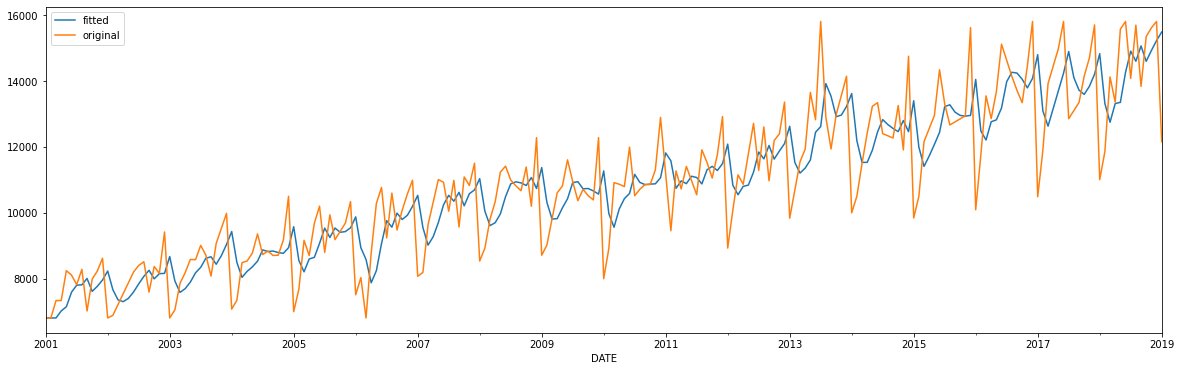

In [ ]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit(smoothing_level=0.4)
model.fittedvalues.plot(label='fitted')
mobile_sales.Sales.plot(label='original')
plt.legend()

This looks like a much better fit than the Simple exponential smoothing.

<br>

Now, lets look at the forecasts.
> **Q. Can you imagine what forecasts with this technique would look like?**

As per the simple exponential technique, we were just getting a straight line of forecasts.

Here, we've incorporated the trend value of the entire time series also.

We know that the trend for given series is increasing.

So perhaps, we will get a plot with forecasts along the trend line.


![picture](https://drive.google.com/uc?export=view&id=1qvZ_1Jn346phEcAzJnnZpuXgqAXzjLrv)

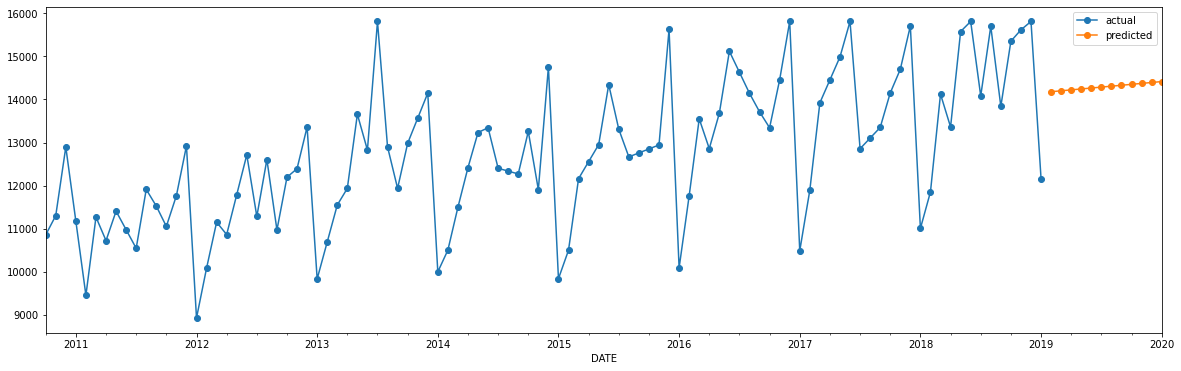

In [ ]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o', label='actual')
pred.plot(style='-o', label='predicted')
plt.legend()

From the graph you can see that, the trend of the series is also obtained along with the level of values.

<br>


> **Q. What would be the performance of the Double Exponential model?**

While we're at it, let's check the performance of Holt's method model also, by using train and test sets.

MAE : 1167.938
RMSE : 1356.131
MAPE: 0.083


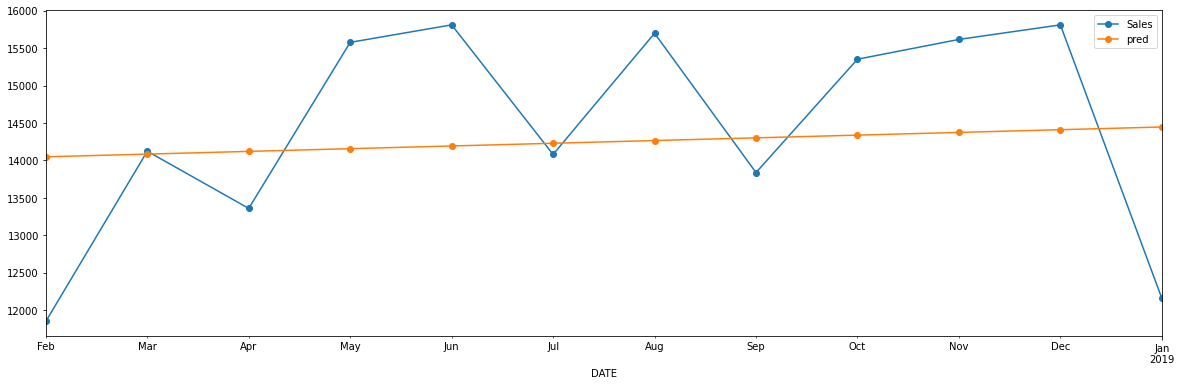

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps = 12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Again, the error has reduced to 8.3% now.

Also, the MAE and RMSE values also dropped.

---

## 4. Triple Exponential smoothing (aka Holt-Winters Method)

> **Q. What can we do to further improve the quality of our forecasts?**

We can perhaps add the seasonality of the timeseries also, that way we'll get rid of the straight line forecasts.

<br>

>**Q. How does this change the math formulation?**

Upon incorporating the seasonality, our equation becomes,

$\hat{y}_{t+h} = l_t + hb_t + s_{t+h-m}$

where m -> frequency of the seasonality, i.e., the number of seasons in a year.

For example, for quarterly data m=4, and for monthly data  m=12.

Here,

$l_t = α (y_t - s_{t-m}) + (1-α)(l_{t-1} + b_{t-1})$

$b_t = β (l_t - l_{t-1}) + (1-β)b_{t-1}$

$s_t = γ (y_t - l_{t-1} - b_{t-1}) + (1-γ)s_{t-m}$


![picture](https://drive.google.com/uc?export=view&id=1bYC7H3ILQ3yaZ6hixpykuyuCUX6MlK2h)



> **Q. How can we implement triple exponential smoothing in code?**

Within our `ExponentialSmoothing()` function of statsmodels, we can assign the parameters `trend=True` and `seasonal=True`.

This way, the trend and seasonality get incorporated into the smoothing function.

Let's see the plot after triple exponential smoothing.

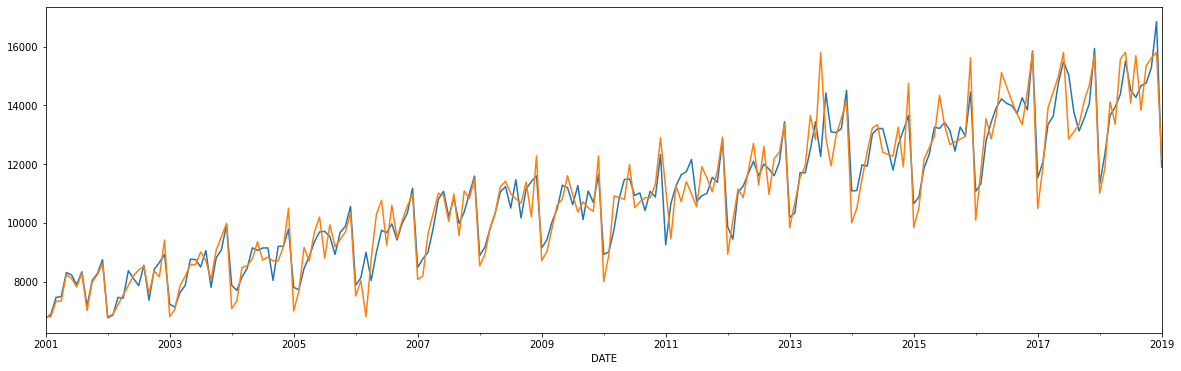

In [ ]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=0.4)
model.fittedvalues.plot()
mobile_sales.Sales.plot()

As you can see, this captures more information than Double Exponential smoothing.

This was expected as it has more degrees of freedom to capture more data.

<br>

Now, lets look at the forecasts.
> **Q. Can you imagine what forecasts with this technique would look like?**

As per the double exponential technique, we were just getting a straight line of forecasts along the trend line.

Here, we've incorporated the seasonality value of the entire time series also.

So perhaps, we will get a good forecast now.

![picture](https://drive.google.com/uc?export=view&id=1FextDENk7sSpUtCuT_IkhyJrx4mc4iEG)

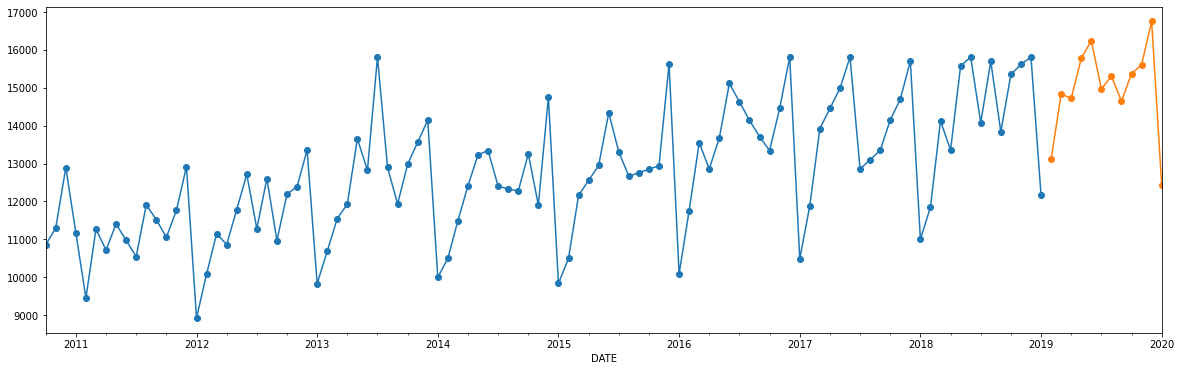

In [ ]:
pred = model.forecast(steps = 12)
mobile_sales.Sales.tail(100).plot(style='-o')
pred.plot(style='-o')

From the plot we can see that our forecasts now look promising upon incorporating the trend and seasonality components.

<br>


> **Q. What would be the performance of the Triple Exponential model?**

While we're at it, let's check the performance of Holt-Winter's method model also, by using train and test sets.

MAE : 588.607
RMSE : 680.844
MAPE: 0.04


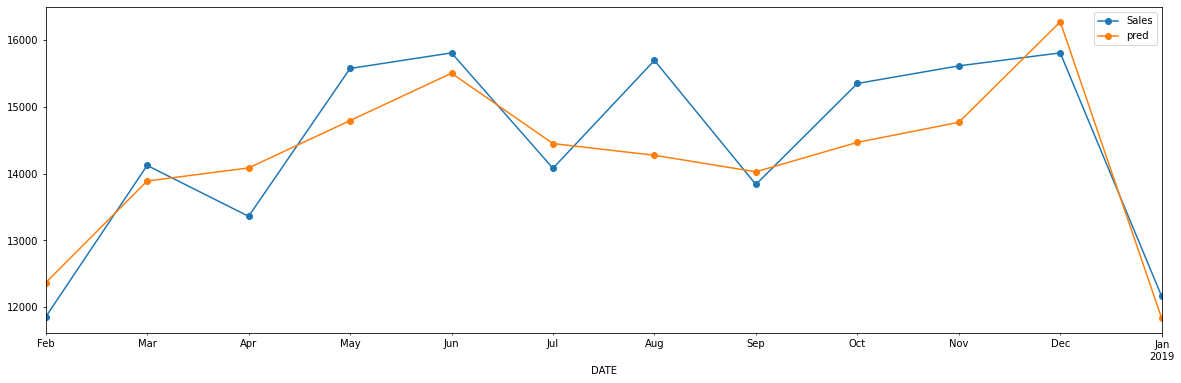

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

In this plot we can clearly see that this model is having a better performance.

To back this, we can see that even MAPE error is only 6.8% now.

Also, the MAE and RMSE values have gone down a lot, from where we started.

#### Q. What if we take a mixture of additive and multiplicative models? Would that improve the performance?

MAE : 586.655
RMSE : 654.972
MAPE: 0.04


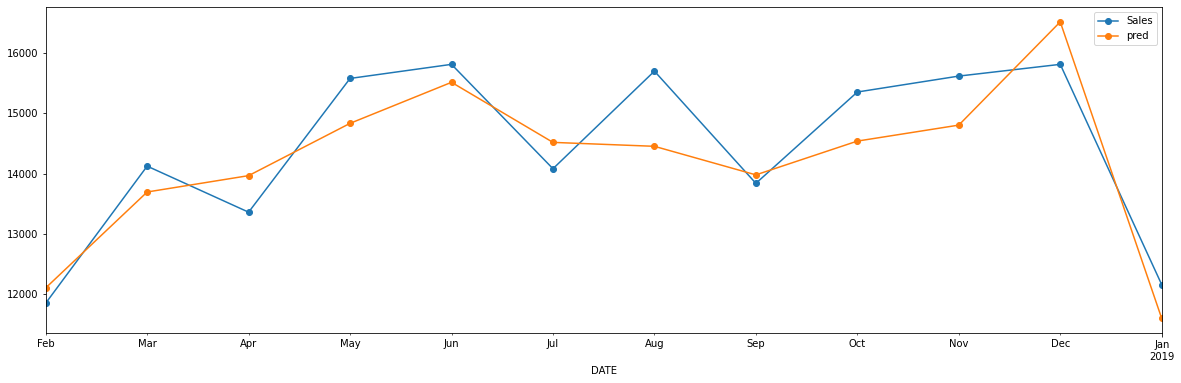

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='mul').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

MAE : 1.8859151244811074e+22
RMSE : 2.27756909503556e+22
MAPE: 1.3166165353677834e+18


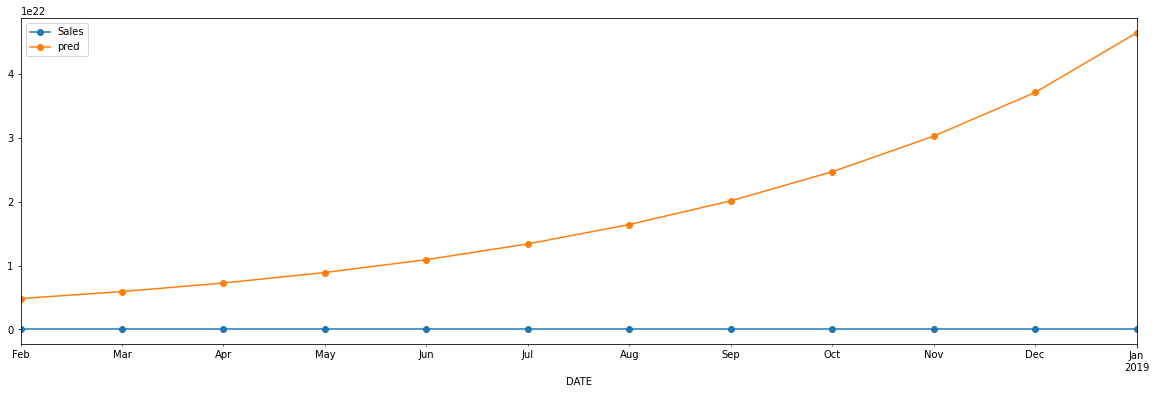

In [ ]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='mul', seasonal='add').fit(smoothing_level=1/(2*12))
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Here we can see that the performance of multiplicative model is better than linear model.

There is no rule for which model model (mul / add) to use when. We need to try and see which performs better.

---

## Stationarity

So far, we've been dealing with non-stationary time series. But in order to use certain forecasting methods (that we will see shortly), we need to the series to be stationary.

> **Q. What does it mean for a time series to be stationary?**

Being stationary means that, parameters (like mean, variance, amplitude, frequency) of the models should **not be dependent on time**.

Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.


**For example:** Heart beats (mean=0; standard deviation=1) is stationary — it does not matter when you observe it, it should look much the same at any point in time.

In general, a stationary time series will have no predictable patterns in the long-term.


<br>

> **Q. Why do we want to know if a time series is stationary?**

If a model's parameter varies over time, then there is a complex relation that needs to be modelled, which all models are not able to account for.

Many models assume the series to be stationary to be able to give useful results.

So, either we want to have a stationary time series, or convert to it.





<br>

> **Q. Which of the following time series is stationary?**

![picture](https://drive.google.com/uc?export=view&id=1pN4X8e7xNcQvnpgCmGgl7gQZURcD3kRy)

- `a, c, e, f, :` Not stationary
 - either have a trend, or
 - mean changing with time.
- `d, h:` Not stationary
 - Seasonality
- `i:` Not stationary
 - Has a trend
 - Variance is also not stable
 - Season
- `b:`
 Stationary
 - There is 1 outlier
 - Can't say anything about mean; seems to be just noise.
- `g:` Stationary
  - Predicting this is dicey, so we assume it to be stationary, and try building model, and seeing if it performs.
  - Looks like a cyclic time series. But these are not at regular intervals.
  - So, even though there  is some seasonality, it can't be predicted.

Categorizing a time series by just looking at it can be a little subjective.

For example, somebody may argue that `plot b` is non-stationary, as it looks like there may be some seasonality there.

### Dickey-Fuller Test

> **Q. Is there a test to help determine stationarity?**

There is a **statistical** method called **Dickey-Fuller test**, designed for testing for stationarity.

It fits an auto regressive model, checks if it worked or not. If it did, then that means it was a stationary time series.

There is a complicated mechanism to it. We don't need to know how it works. Just need to be aware of this test, as it can be handy.

<br>

> **Q. How can we implement Dickey-Fuller Test?**

We can find this as a built in function under **statmodels** library as `sm.tsa.stattools.adfuller()`.

<br>

> **Q. How do we interpret the result of Dickey-Fuller test?**

This test returns the **pvalue**.

In order for a time series to be stationary, the **pvalue** should be less than 0.05

Let's do the test for our timeseries

In [ ]:
sm.tsa.stattools.adfuller(mobile_sales.Sales)[1]

0.9789233920172066

The pvalue of the timeseries is very high, 0.98 approx.

So we can conclude that our time series is **not stationary**.

This makes sense because our time series has both, trend and seasonality.

Let's define a simple function to know if the plot is stationary or not.

In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')


In [ ]:
adf_test(mobile_sales.Sales)

Sequence is not stationary


So, we've established, our time series is not stationary. We need to tackle this.

<br>

> **Q. How do we convert a non stationary time series into a stationary time series?**

As per basic intuition, if we remove trend and seasonality, from our time series, it should become stationary.

If it's still not stationary, then maybe there's still some seasonality or trend component left in the series.

Ideally, trend gets removed in one step. However seasonality can take multiple steps to be removed.

These processes are called **Detrending** and **Deseasonalising** respectively.

---

### De-trending



Recall from the trend-seasonality decomposition that a time series can be written as <br>
$\hat{y_t} = m*x_t + c + s(t) + r(t)$ <br>
where $m*x_t + c$ represents the trend component

<br>

> **Q. How can we remove trend from the time series?**

In order to remove this, we can **differentiate** $\hat{y_t}$, with respect to time t. This way, we'll get a stationary time series. This gives us

$\frac{d\hat{y_t}}{dt} = m$, which is a constant.

One way to compute $\frac{d\hat{y_t}}{dt}$ is:

$\frac{d\hat{y_t}}{dt} \approx lim_{Δt → 0} \frac{y(t+Δt) - y(t)}{Δt}$

The minimum value of $Δt$ that we have is 1, since we're talking in terms on time, and our minimum step is 1 month. So the equation becomes: $\frac{d\hat{y_t}}{dt} \approx \frac{y(t+1) - y(t)}{1}$


This process is called **differencing**.

**Note:**
- Differencing gives a good approximation of differentiating
- Differentiating gives us a De-trended time series.


![picture](https://drive.google.com/uc?export=view&id=1Admg_50OXls05ZTytHbrNRpZtdHv4mpC)

<br>

> **Q. What if the trend line is not linear?**

If the time series has a non-linear trend, then we'll have to differentiate it multiple times, in order to finally achieve a stationary series.

**Note:**
- If the trend is an exponential function, then we'll not be able to convert it into stationary.
- This is a very rare cases.
- Some exponential functions can be approximated by polynomial. In that case, we differentiate this polynomial to obtain a stationary time series.

<br>

> **Q. How is this concept of differencing implemented?**

A new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step.

$value(t) = observation(t) - observation(t-1)$


![picture](https://drive.google.com/uc?export=view&id=1XeLBXvc1jdUbrQQ6p94QvazTPlQmngTg)

This has the effect of removing a trend from a time series dataset.

<br>

Lets look at our series first.

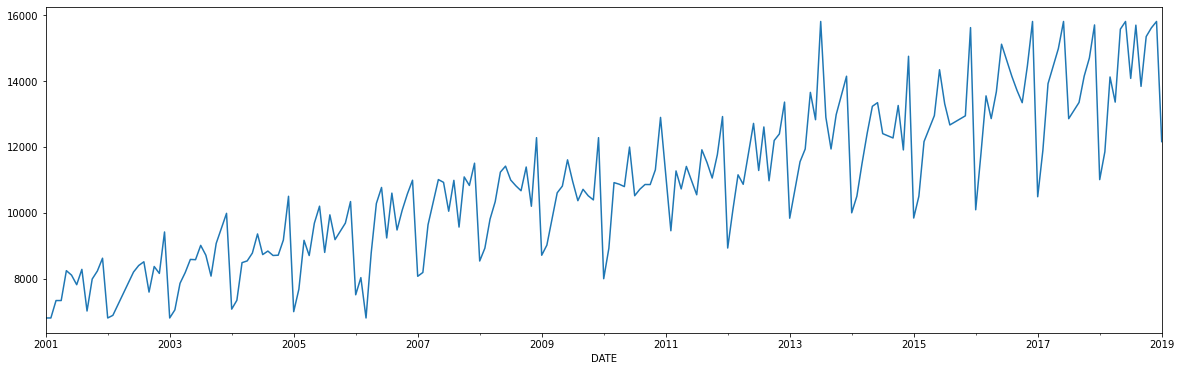

In [ ]:
mobile_sales.Sales.plot()

> **Q. How can we implement this concept of differencing in code?**

We use the `diff()` method of **pandas**.

This method calculates the difference of a Dataframe element compared with another element in the Dataframe (default is element in previous row, as the default value is 1).

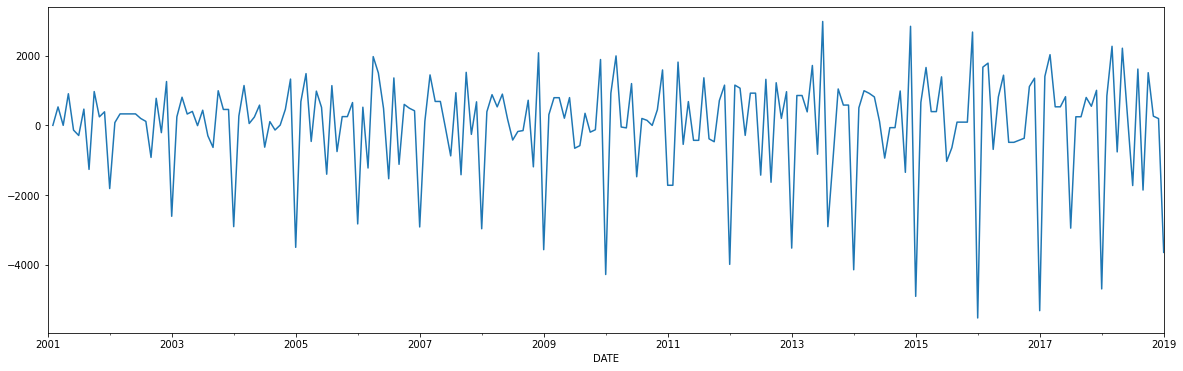

In [ ]:
detrend = mobile_sales.Sales.diff()
detrend.plot()

As you can see, here the series has been detrended.

Let's perform the Dicker-Fuller test to cross check.

In [ ]:
adf_test(detrend.dropna())

Sequence is stationary


Though very less, there is still some seasonality, as can be seen.

### De-seasonalising

> **Q. How can we remove seasonality from the time series?**

Here also we can use differencing, but instead of subtracting from the last point, we need to take a difference from the last mth point, where m is the period of seasonality of series.

$Δy = y_t - y_{t-m}$

This is called **m-differencing**.

If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week.

In our case, since data is monthly, our m=12

![picture](https://drive.google.com/uc?export=view&id=1azP2NXIJjuvDb8gbwNJpIkuqSKdLiyT_)

<br>

> **Q. How can we implement this concept of differencing in code?**

Again, here also, We use the `diff()` method of **pandas**.

This time, since as per our data, m=12, we pass this as the parameter in `diff()`.

Now, lets do the **de-seasoning** and see the plot

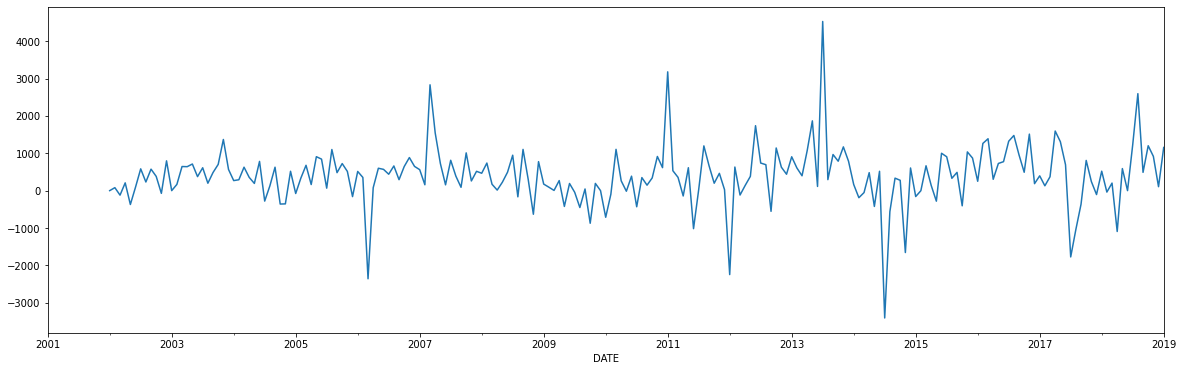

In [ ]:
deseas = mobile_sales.Sales.diff(12)
deseas.plot()

Here, as you can see we can still see very small trace of trend still.

Let's try detrending AND deseasonalising at once.

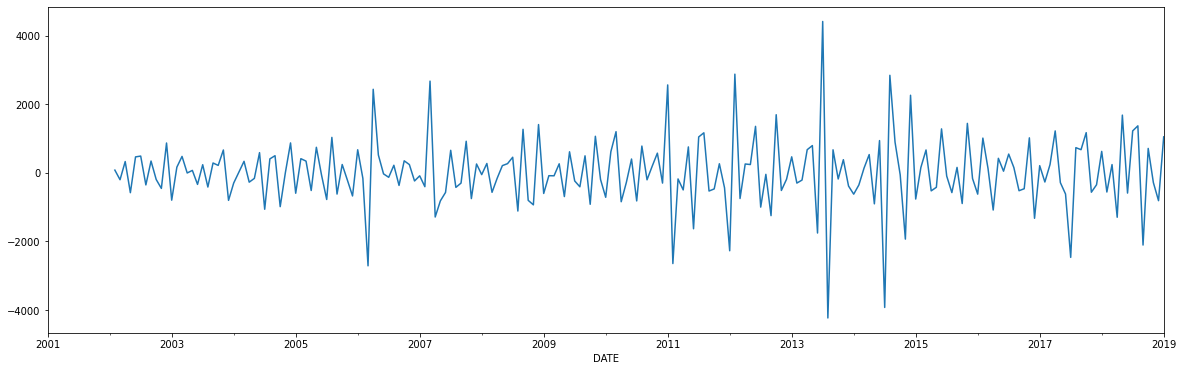

In [ ]:
stationary = mobile_sales.Sales.diff(1).diff(12)
stationary.plot()

As you can see, we've obtained a stationary time series.

**We have removed both trend and seasonality from the time series. So now all we have left is the error values:**

$y(t) - b(t) - s(t) = e(t)$

<br>

> **Here, we could visually see in the plot that value of m seems to be 12, but in other cases, it might not be obvious.**
- So we need to find the optimal value of m.


## AutoCorrelation and PartialAutoCorrelation

#### Q. How to get the optimal value of m?
- One approach is that we find local maximas and minimas in the time series, and try to analyse the intervals at which they are observed.
 - This approach makes sense.

Let's look at another approach.
- Given our current time series $y(t)$,
 - What if we consider another time series where we introduce a **lag** of 1, i.e. **shift the series** by 1 unit of time: $y^1(t)$
 - We can then find the **correlation coefficient** between these two time series: $y(t)$ and $y^1(t)$
 - Similarly, we find the correlation between the original time series $y(t)$ and a time series lagged by i units: $y^i(t)$, where $i=1,2,3,...$ (i represents lag)
 - In doing so, we would find a value of $i$, where the lagged time series **rougly overlaps** over the original series.

![picture](https://drive.google.com/uc?export=view&id=1O2mUAl5azcKXOPkfDP6FJkrR6Yv-Vd6c)

<br>

Then, we create a table containing: $y(t)$ and $y^i(t)$ time series values

When $i=m$ (the lagged time series **rougly overlaps** over the original series), the **Pearson correlation coefficient** would be very close to 1.

This value of $i$ would indicate the optimal value of $m$.

![picture](https://drive.google.com/uc?export=view&id=16M3jlYHbxfD-je8s03liBHJdfe-Ie_L6)


<br>

> **Q. What are the advantages of using concept of correlation for finding optimal value of m?**

- Easily interpretable
- Value ranges from -1 to +1
- Captures linear relationship

<br>

> **Q. What will the plot between correlation coefficient and lag (i) look like?**

- At $i=m$, we would get a correlation value very close to 1.
- At $i=m/2$, as the value of lagged time series increases, the value of original series decreases, giving us a **strong correlation**

- For a value of $i$ that is even close to $m$, though the correlation value would not be as strong as at $m$, but it would be relatively strong.

![picture](https://drive.google.com/uc?export=view&id=15fpjhdBoK4pQEtCTclAsH1kM5zl94fd8)

So, the final plot between lag value (i) and correlation coefficient would look something like:-

![picture](https://drive.google.com/uc?export=view&id=1L49RsxvaijEztWVSTUa3Gd_rtVdZBzz1)

This plot is called **Autocorrelation Plot** because we are computing correlation of the time series with itself with various values of lag.

This can be written as a function also. That is called **Autocorrelation Function (ACF)**.



> **Q. How can we create a lag time series in code?**

We have a function in **pandas** library called `shift()` that can be utilised for this.

We pass the value of how many time units we wish to shift the time series by.



Let's see what the head of data looks like.

In [ ]:
mobile_sales.Sales.head()

DATE
2001-01-01    6802.44
2001-02-01    6802.44
2001-03-01    7332.00
2001-04-01    7332.00
2001-05-01    8240.00
Name: Sales, dtype: float64

Let's shift this by 1, and see what happens.

In [ ]:
mobile_sales.Sales.shift(1).head()

DATE
2001-01-01        NaN
2001-02-01    6802.44
2001-03-01    6802.44
2001-04-01    7332.00
2001-05-01    7332.00
Name: Sales, dtype: float64

Hence you can see that since now the first value in shifted time series becomes NaN, we need to skip those values while calculating ACF and PACF.

> **Q. How will we calculate correlation between two time series?**

We have the `corrcoef()` function in **numpy** library that can be utilised for this.

In [ ]:
lag = 1
np.corrcoef(mobile_sales.Sales[lag:], mobile_sales.Sales.shift(lag)[lag:])[0][1]

0.8002851477229684

We can change the value of **lag** above to see what happens for different values.

We can see that as we increase lag, the correlation decreases. At 13, it increases again.

Let's plot this.

> **Q. How can we plot the ACF and PACF values?**

There are functions in **statmodels** library, called `plot_acf()` and `plot_pacf()`, that can help here.

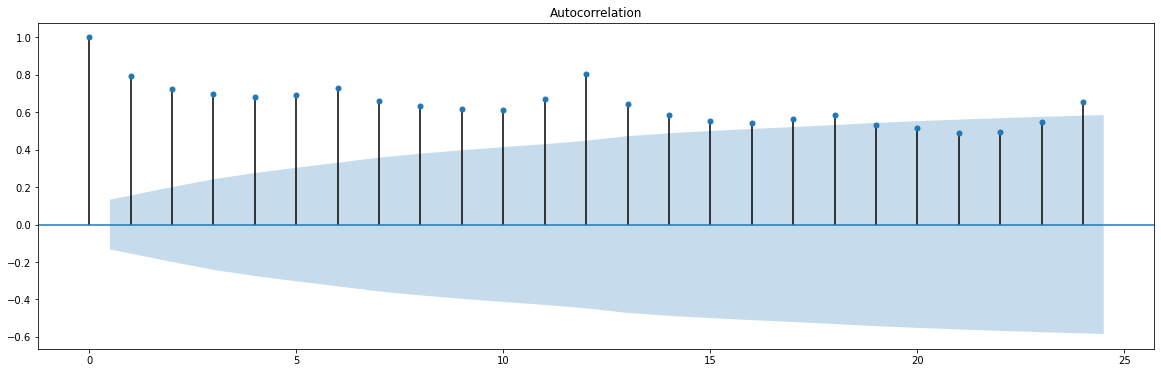

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(mobile_sales.Sales);

- From the plot we can see that the correlation value increases at every six months which we couldn't recognise just by looking at the actual data plot. So there is also a **6 month seasonality**.

- It peaks every 12th month.

<br>

For this time series, correlations are quite high.

Let's see the ACF plot for the **de-trended series**. Because intuitively also, finding seasonalities on a de-trended series would be better.

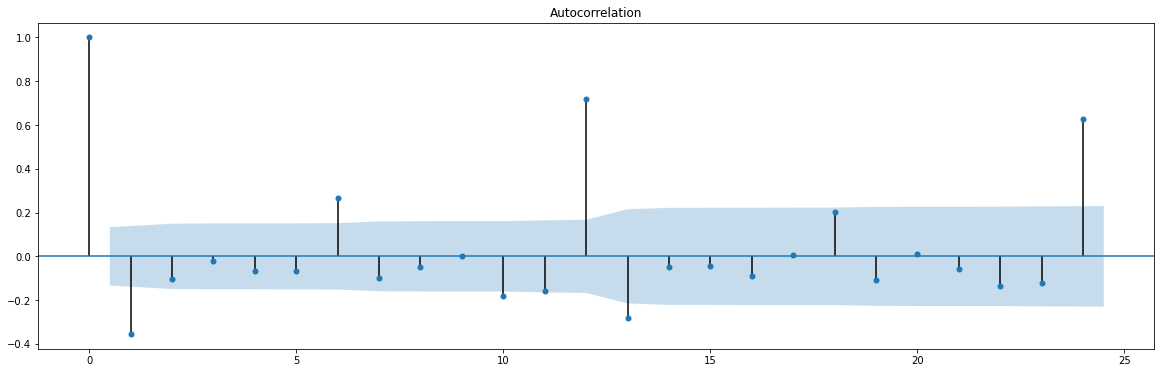

In [ ]:
plot_acf(mobile_sales.Sales.diff().dropna());

- After de-trending the series, we can see the correlation of the series is high at period of 12 and 6. This indicates there is some seasonality.

- Besides that, the correlation values are random and small.
- On removing the trend, we're **able to capture negative correlations** between the original series and lagged series with more ease.
 - As per business logic, we can expect to see a dip right after peak/holdiday season.

<br>

> **Q. What does the blue shaded region signify?**

// significance
The blue colour highlighted part is the **confidence interval** which gives the significance level of the correlation

**If the correlation is higher or out side of the blue highlighted area, that can be considered as the highly significant value.**

So the major values of lag we consider to study the seasonality pattern here are:-
- Correlation at lag=1
- Correlation at lag=6
- Correlation at lag=12
- Correlation at lag=24

Other points lie within or very close to the blue shaded region of confidence intervals.
- This means that we are not very confident about these correlation values.

**The confidence interval increases as we consider time series that are lagged more**

<br>

We will study about confidence interval in depth in the next class.

Let's do the de-seasoning, in order to get a **stationary series**, and see the ACF for it.

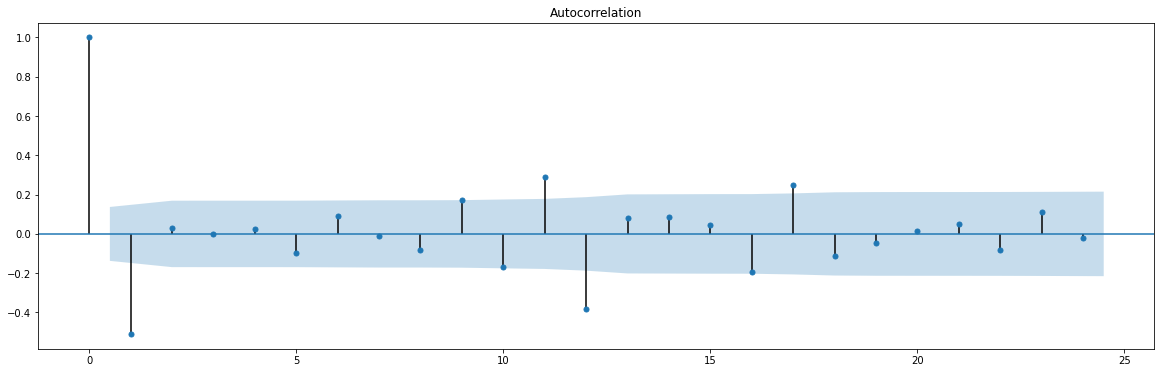

In [ ]:
plot_acf(mobile_sales.Sales.diff().diff(12).dropna());

Here we can see the significant decrease in the correlation values , that means seasonality is reduced

Even though some points are outside the confidence interval, we need not worry about them. We should only consider the points if they have a value >0.7, that is when they're significant.

Otherwise, we can choose to ignore it, it won't have that much of an effect.

---

Let's take a look at another concept: **Partial Auto Correlation Function (PACF)**

<br>

#### Q. What is meant by Partial Auto Correlation?
- This is similar to AutoCorrelation with only a small difference.
 - Here also, we are trying to find a relationship between the original time series $y(t)$ and time series lagged with $i$ steps $y^i(t)$, where $i=1,2,3,...$, to find the optimal value of $m$.

-The difference is that: **All intermediate/indirect correlations are removed**.
 - The correlation between observations at successive time steps is a linear function of the indirect correlations.
 - These indirect connections are eliminated using the **partial autocorrelation function (PACF)**.

For example
- When we're considering the correlation between $y(t)$ and say, $y^{12}(t)$,
 - Then, we do not want this correlation value to get corrupted by the correlations when $i=1,2,3,...,11$ (i.e. the intermediate correlations)

![picture](https://drive.google.com/uc?export=view&id=1Pa_-5BRwzdAil1fW4VB8Fbu7r2pkPGd0)

<br>

> **Q. What does PACF value indicate?**

The partial correlation for each lag is the **unique correlation** between the two observations after the intermediate correlations have been removed.

This is also known as **Conditional AutoCorrelation**.


![picture](https://drive.google.com/uc?export=view&id=1InkWEs38TKMPgG03JMv9VxjXxbbyAseV)

<br>


Let's have a look at the Partial Auto Correlatio Plot (PACF)

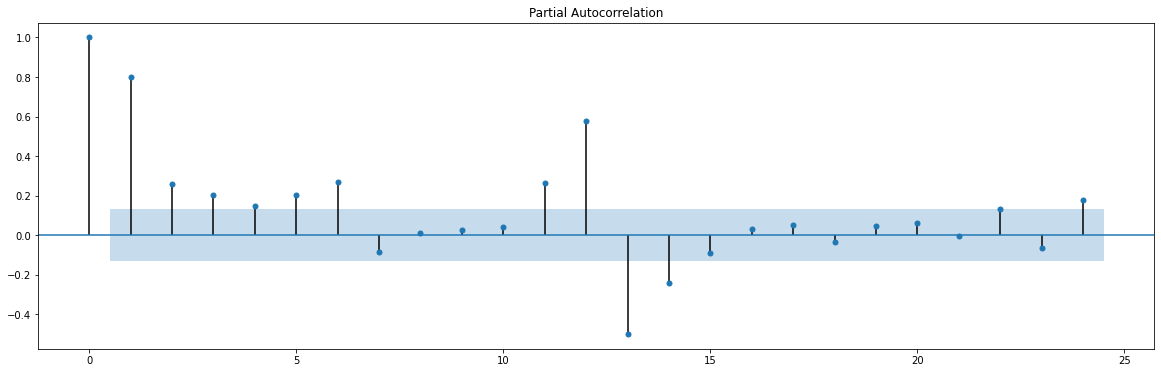

In [ ]:
plot_pacf(mobile_sales.Sales);

This PACF makes the correlation clear.

**Interpretation:-**
- Value at $i=1$ is high: This means that given the values of time series $y(t)$, we can compute the values of a time series with lag 1, $y^1(t)$ with ease.
- There is a high value at $i=12$
 - This means that even if we ignore the information given by all the time series with $lags=1, 2, ..., 11$, the information carried in time series $y^{12}(t)$ alone is very high.
 - This shows strong seasonality

<br>


**Observations:-**
- Autocorrelation plot is as expected; series does not seem to be stationary
- Diff series is indeed stationary. Also, seasonality can be seen using this plot.
- De-seasoned series does not have any seasonality or trend.
- PACF suggests that only the first lag and 12th lag is strong.

> **NOTICE:-**
- We calculate PACF on the original time series, whereas ACF is plotted on stationary time series.

## Correlation Vs Causation

> **Q. If a variable x is correlated with another variable y, does that mean that x causes y?**

A variable x  may be useful for forecasting a variable  y, but that does not mean x is causing y.

For example,
- it is possible to model the **number of drownings at a beach** resort each month with the **number of ice-creams sold** in the same period.
- The model can give reasonable forecasts, not because ice-creams cause drownings, but because people eat more ice-creams on hot days when they are also more likely to go swimming.

So the two variables (ice-cream sales and drownings) are **correlated**, but one is **not causing** the other.

They are both caused by a third variable (temperature).

This is an example of **confounding**.

<br>

> **Q. What is the relevance of correlation and/or causality with forecasting models?**

Correlations are useful for forecasting, even when there is no causal relationship between the two variables.

For example,
- It is possible to forecast if it will rain in the afternoon by observing the number of cyclists on the road in the morning.
- When there are fewer cyclists than usual, it is more likely to rain later in the day.

This model can give reasonable forecasts, not because cyclists prevent rain, but because people are more likely to cycle when there is less or no chance of rain.

In this case, there is a causal relationship, but in the opposite direction to our forecasting model.

<br>

> **Q. If we can get good forecasts based on correlated variables, why bother trying to understand the causality behind them?**

Though we can get good forecasts based on correlated variables, if we try and understand the causality behind those variable, we can identify better features, thereby creating a better model.

- A better model for drownings example will probably include **temperatures** and **visitor numbers** and exclude ice-cream sales.

- A good forecasting model for rainfall will not include cyclists, but it will include **atmospheric observations** from the previous few days.


---

# ARIMA Family of Forecasting Techniques

## 1. Auto Regression (AR)

So far, the models we've seen, assume a trend and seasonality component.

But what about the case of stationary series?

#### Q. How can we forecast future values, if our given time series is **stationary**?
In this case, we're kind of helpless, because there is no pattern in the series.

Any trend or seasonality that was present, has been removed from series, and it will be added back later, in the final prediction.


![picture](https://drive.google.com/uc?export=view&id=1C74RnJtALGtBth9BtPn4U7yPvOkuclE0)

For such cases, we study this new family of models, called **ARIMA Family**.

Though such series look like they are completely random, there is still some extent of forecastability here,

There is still information left to be extracted from stationary series.

<br>



> **Q. What if we had a feature in our time series, besides the value to be predicted?**

In that case, we could just utilise **Linear Regression**, by mapping this feature's values with the value to be forecasted.

<br>

Let's use this idea and create another feature, so that we can utilise Linear Regression.
> **Q. How can we create a new feature for the stationary time series?**

We can map the value of the stationary time series at time $t$ with the value of series at time $t-1, t-2, t-3, ..., t-p$, where p could be a **hyperparameter** we set.

This way, now our data becomes as shown.
- It contains date as index,
- Past values $y_{t-1}, y_{t-2}, ..., y_{t-p}$ as features and
- value at time $t$ as the value to be predicted ($\hat{y_t}$)

Now we can successfully implement Linear Regression using these features.


![picture](https://drive.google.com/uc?export=view&id=18rSdp8emwX4irFh3rdrxGkXhtaSB0O3A)

<br>

#### Q. What does the math look like?
Essentially, we're converting our forecasting problem to Linear Regression.

We're saying that,

Future value $\hat{y}_t$ = LinearRegression(Past p values)

Recall the Linear Regression lecture, this converts our problem into following form

$ŷ_t = α_0 + α_1y_{t-1} + α_2y_{t-2}... + α_p y_{t-p}+ ϵ_t$

where
- $α_0$: intercept (parameter)
- $ϵ_t$: error term
- $α_1, α_2, ..., α_p$: weights (parameters)
- $p$: No of past values to be considered (hyperparameter)

Hence, this is also known as the **AR(p) model**

![picture](https://drive.google.com/uc?export=view&id=1i4_2H16WjtlLb1Tns19T5iPNi4np2lM1)

<br>

Recall the Simple Exponential Model. The formulation there was also similar to the one we have for AR(p) model:
 $ŷ_{t+1} = αy_{t} + α(1-α)y_{t-1} + α(1-α)^2ŷ _{t-2} + ...$

This also seems like a form of regression model.

> **Q. How is SES different from AR(p) model?**

Though we are essentially doing a **weighted average** of the past time series values in both SES and AR models, there is a fundamental difference.

In case of SES,
- The weights are **exponentially decaying**
- The hyperparameter is $α$

In case of AR,
- The weights are **learnt** by multiple iterations.
- The hyperparameter is $p$

![picture](https://drive.google.com/uc?export=view&id=1dxZSaNyRSa4mWOeNbC4QmTkAqsVcdRu6)


<br>

> **Q. Are there any conditions for the AR model to be true?**

- The idea is that, this assumption will be true if the **Partial Auto Correlation Plot** has a high value at lag = k.

- This way, from the plot we know that the future value is highly correlated with one value in the past, which means that it makes sense for us to compute linear regression on past 1 value.

- We are using PACF because we dont want features to be correlated with each other in LR. PACF can help to identify that




<br>

> **Q. But how can we decide the value of p?**

The same way as before.

We look at the **PACF plot**, and based on the values there, we decide how many lag values we can consider.

For example, in the given plot,
- we consider 2 lags only,
- as for the third lag, the PACF value is 0.1,
- so considering it will not give as promising results.


![picture](https://drive.google.com/uc?export=view&id=1yMGT_P8ZO95-tCFcS8UU0BHJusstGa2R)

<br>



Before applying the AR Model, let's check the nature of our time series right now (stationary/non-stationary) using the `adf_test()`

In [ ]:
train_x.head()

,Sales
DATE,
2001-01-01,6802.44
2001-02-01,6802.44
2001-03-01,7332.00
2001-04-01,7332.00
2001-05-01,8240.00


In [ ]:
def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(train_x.Sales)

Sequence is not stationary


Recall that we need to have a stationary time series to use AR Model.

Let's **de-trend** it by taking a difference of 1.

In [ ]:
train_x_st = train_x.copy()
train_x_st.Sales = train_x_st.Sales.diff(1)
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

Sequence is stationary


> **Q. How can we implement AR in code?**

We import the SARIMAX function from **statsmodel**. We will shortly see what SARIMAX itself means.

We have to pass `order` parameter. It accepts a tuple of 3 values, we will see what these values mean.

For now, in order to implement pure AR, we pass `(1,0,0)` to `order`, where 1 specifies the order we wish to use for AR. We can change this order as per our choice.

In [ ]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(1, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x['pred'].head(20)

DATE
2018-02-01    1728.700558
2018-03-01    -635.966295
2018-04-01     233.963671
2018-05-01     -86.072170
2018-06-01      31.664824
2018-07-01     -11.649074
2018-08-01       4.285542
2018-09-01      -1.576595
2018-10-01       0.580009
2018-11-01      -0.213378
2018-12-01       0.078499
2019-01-01      -0.028879
Name: pred, dtype: float64

Since we've gotten the forecasts from the de-trended series, we need to **integrate the trend back**, in order to obtain the true value of our forecasts!

In [ ]:
# Integrate !!

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

MAE : 2307.213
RMSE : 2585.999
MAPE: 0.153


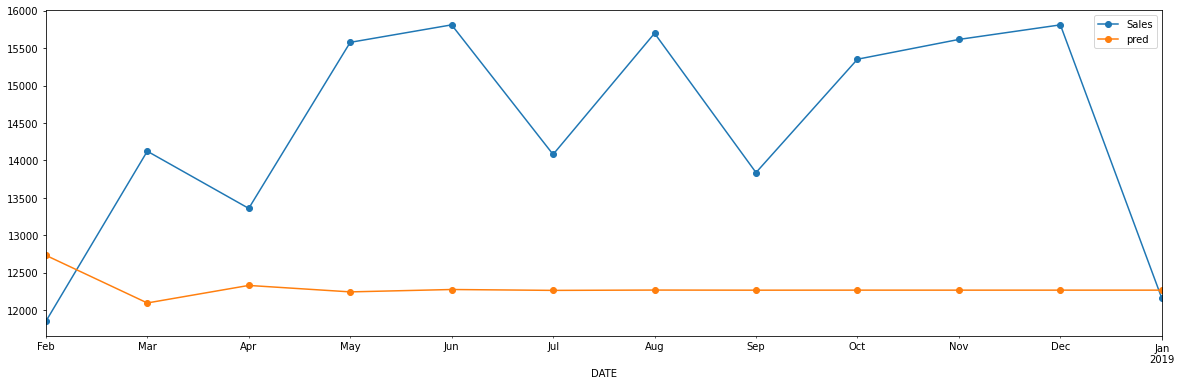

In [ ]:
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

This is not performing that well. Let's see what the optimal value for order should be by looking at PACF plot.

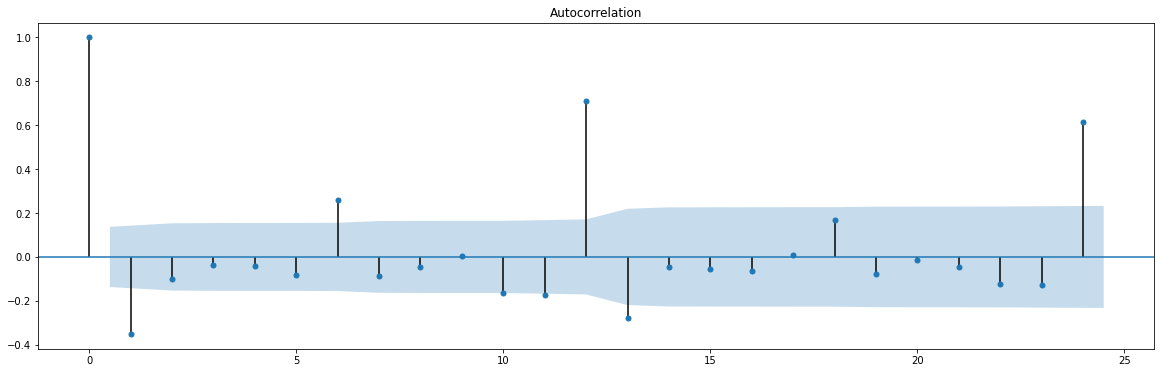

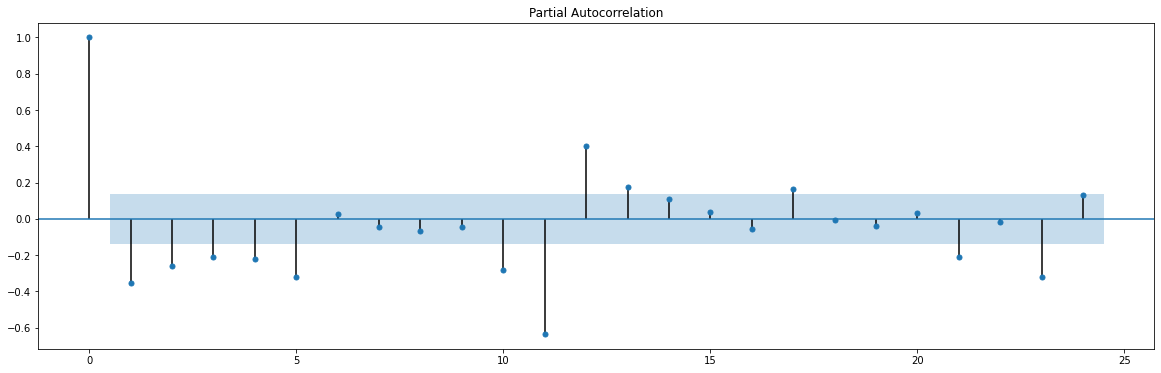

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(train_x_st.Sales);
plot_pacf(train_x_st.Sales);

> **GUIDE**
> - **If the ACF plot gradually decreases, and PACF plot suddenly cuts of after lag k, then we can consider AR model with order p=k**
> - Here, there is also some seasonality which we did not remove, maybe there is also some quaterly seasonality, which is why the above rule does not give a clear guess -- Human judgement call needed here

From here, we see the best value is 3. Note that -ve is also significant. (Here it could also be 4-5, but taking a judgement call, later correlations maybe due to some more left over seasonality).

Lets try that

MAE : 1647.061
RMSE : 1890.003
MAPE: 0.11


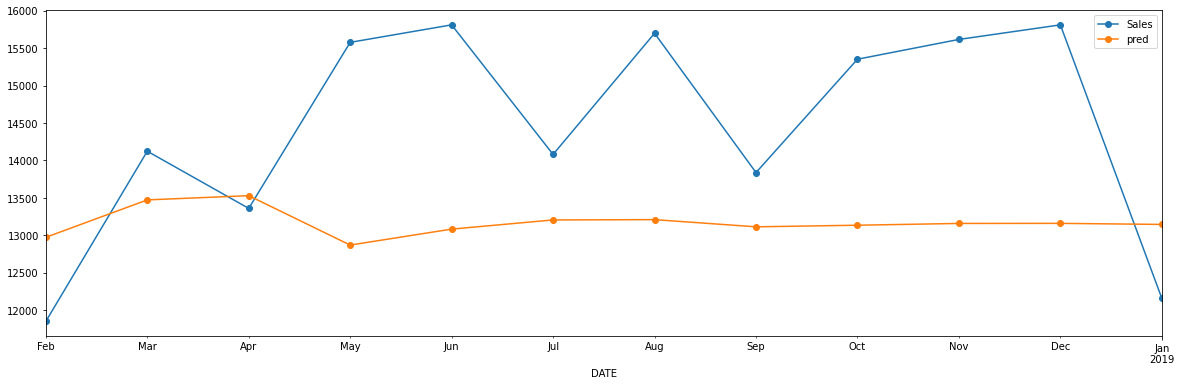

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 0))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---

## 2. Moving Averages (MA)

> **Q. What if instead of using the value of series at time t-1, we use the `error` of value at t-1 from the mean of data in the regression setup?**

The error of each data point in the series from the mean/average, would be different.

This should also work, as we are able to successfully create a new feature that is unique for each point.


In fact, this idea is called the **Moving Averages (MA)** technique.

Though the name is same as the smoothing technique, we looked at before, this has nothing to do with that, and is a completey different concept.


![picture](https://drive.google.com/uc?export=view&id=1zZ-W4FAvsKHUFarx1wc_uFHv6GHuNFvm)

<br>

#### Q. How does this change the math?

This moving average is slightly different from the AR, the formulation becomes,

$ŷ_t = μ + me_{t-1}$

where,
- $μ$ -> mean of entire data
- $e_{t-1}$ -> error of the data point at time t-1, with respect to the mean
- m -> constant

<br>

> **Q. Can we extend this idea to the order of `q` as well?**

**Yes.**

We can also have moving average of order $q$. The formulation becomes,

$ŷ_t = μ + m_1e_{t-1} + m_2e_{t-2}... + m_qe_{t-q} + ϵ_t$

Here, the ϵ represents the final error remaining that is actually truly random, which we cannot help. This is also added for representation.

<br>

**Note:-**
- `q` becomes the **hyperparameter** for MA(q) model
- In case of MA, there is fixed way to determine value of `q`, we need to try a bunch of different values to find the best fit.


![picture](https://drive.google.com/uc?export=view&id=1THdJnn_MQFLQ7e8_ewLH32O7FpAThfzy)

<br>

> **Q. How can we implement MA in code?**

The same way as AR.

Only, the order in which we give value to `order` changes.

Now, we make the first value in tuple as 0, indicating that we do not want any AR, and we specify the order in the third value as the order for MA.

Let's plot it and see

MAE : 1362.947
RMSE : 1558.015
MAPE: 0.093


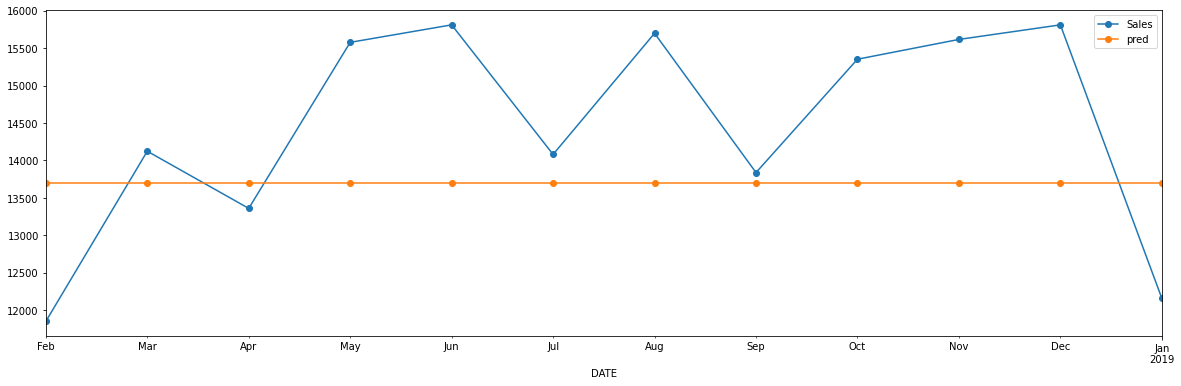

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 1))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Great.

Lets try 3 as order of MA. (Just doing some manual trial and error)

> **GUIDE**
> - **If the PACF plot gradually decreases, and ACF plot suddenly cuts of after lag k, then we can consider MA model with order p=k**
> - Here, its not very clear and so we cannot easily judge the best MA value

MAE : 1359.181
RMSE : 1555.968
MAPE: 0.092


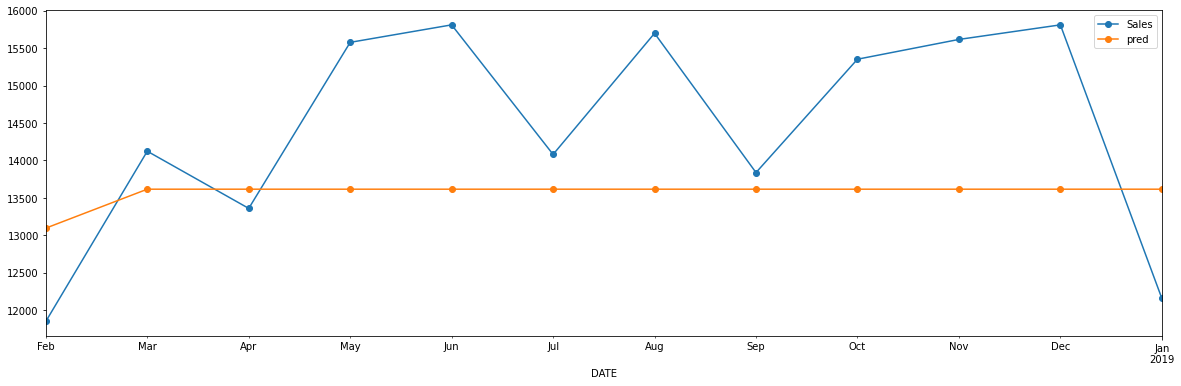

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(0, 0, 2))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---

## 3. Auto Regression - Moving Averages (ARMA)

> **Let's combine the two ideas of AR and MA**

This combined technique is called the **ARMA Model**.

<br>

#### Q. How is the ARMA model formulated?
While combining these two ideas,
- `p`: order of AR  
- `q`: order of MA

 - `p` may or may not be equal to `q`

- $α_1, α_2, ..., α_p$: coefficients of AR
- $m_1, m_2, ..., m_q$: coefficients of MA

The formulation becomes:-

$ŷ_t = c + α_1y_{t-1}...α_py_{t-p} + m_1e_{t-1} + ...m_de_{t-q} + ϵ_t$

i.e. $ŷ_t = c + ϵ_t + Σ_{i=1}^p α_iy_{t-i} + Σ_{j=1}^q m_je_{t-j}$

<br>

**Note:-**
- Here, `p` and `q` are **hyperparameters**
- Hence it is also called as **ARMA(p,q) Model**.


![picture](https://drive.google.com/uc?export=view&id=11q-tInCkM831hjkCyMu7UM3GFntGOXCt)



> **Q. What is the limitation of ARMA method?**

- The major limitation of this technique is that the series should be **stationary**
 - because, if we're training a Linear Regression, the variables can not be dependent on each other.

<br>

Let's see the code part for the same

> **Q. Can anyone guess How to implement ARMA in code?**

We specify order of AR and MA as first and third place in the tuple containing `order` parameter value.

MAE : 1298.685
RMSE : 1521.147
MAPE: 0.088


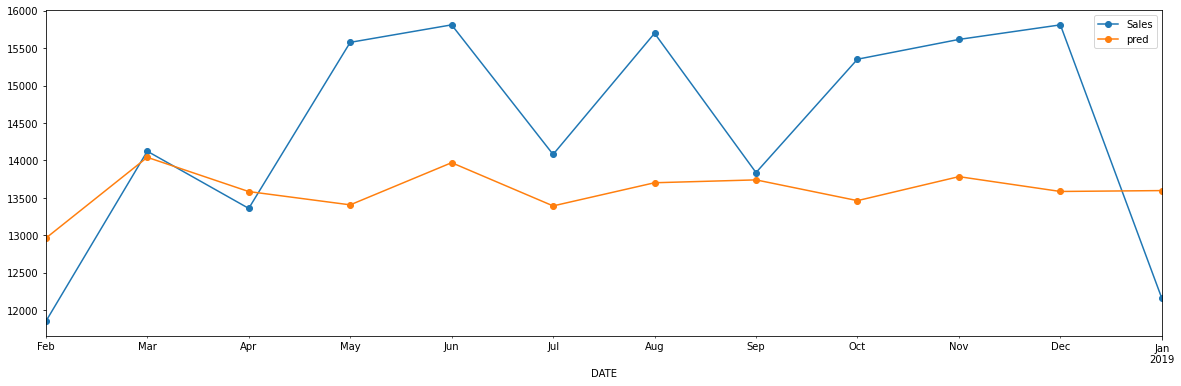

In [ ]:
model = SARIMAX(train_x_st.Sales, order=(3, 0, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

---

## 4. ARIMA

> **Q. What if we do not have a stationary time series?**

In such a case,
 * We perform **differencing** to de-trend
 * Then we apply the ARMA technique, to get an approximation.
 * Now to get a good forecast, we need to **integrate** the trend **back** to get the final result

This technique is called **ARIMA**

Basically, instead of us manually doing integrations (and note that it can get very hard when you need to double / tripple differentiate), we can simple use the ARIMA model, which does this job for us.

<br>

> **Q. How is ARIMA model formulated?**

This can be told as summation of
- Differencing of order `d`
 - d=1 for linear trends, d=2 for quadratic trends, ...
- Auto Regression of order `p`
- Moving Averages of order `q`
- Getting the resulting forecasts
- Integrating `d` times to restore the trend back

$ Integration(d \ times)[ AR (p) + MA (q) ]$

Where $d$ is the number of times the series is differentiated/differenced before applying the **ARMA**



![picture](https://drive.google.com/uc?export=view&id=1k5Xt2sloOOUFiq06xg4zSKPC6gWoExkc)

<br>

> **Q. How to find the optimal values of `p`, `q`, `d`?**

- So, we get **3 hyper parameters** in total: `p, q, d` that we need to tune.
- If the value of `p` or `q` is too large, there's a chance of **overfitting**
- We can tune these using Grid Search


<BR>

> **Q. How to implement this in code?**

Now you can guess that the second value in the tuple of `order` represents Integration value (d).

let's have a look at the plot of it

MAE : 1307.431
RMSE : 1529.153
MAPE: 0.088


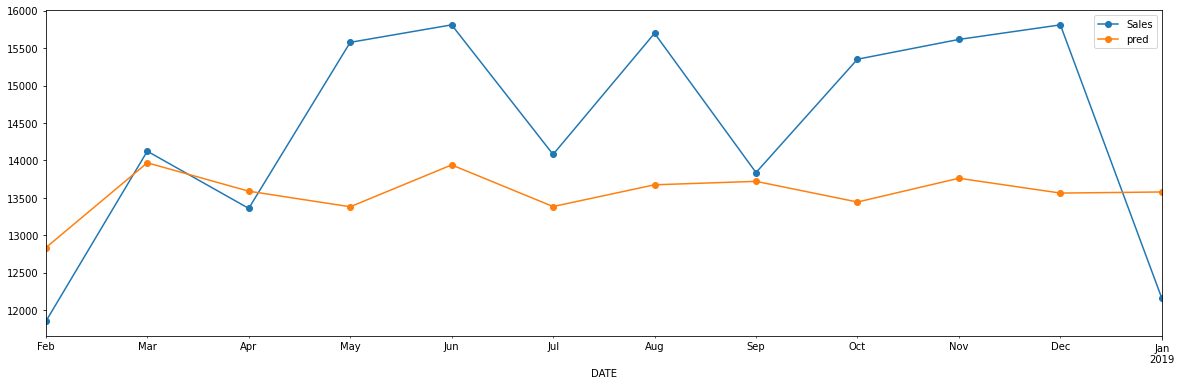

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_x.Sales, order=(3, 1, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

> **NOTICE:-**
- This is the same as us using the ARMA model with manual integration !!
- It means our logic is as good as the authors of statsmodels! That's always encouraging !

Now lets try higher order for differencing and see if that helps.

MAE : 1921.883
RMSE : 2154.918
MAPE: 0.128


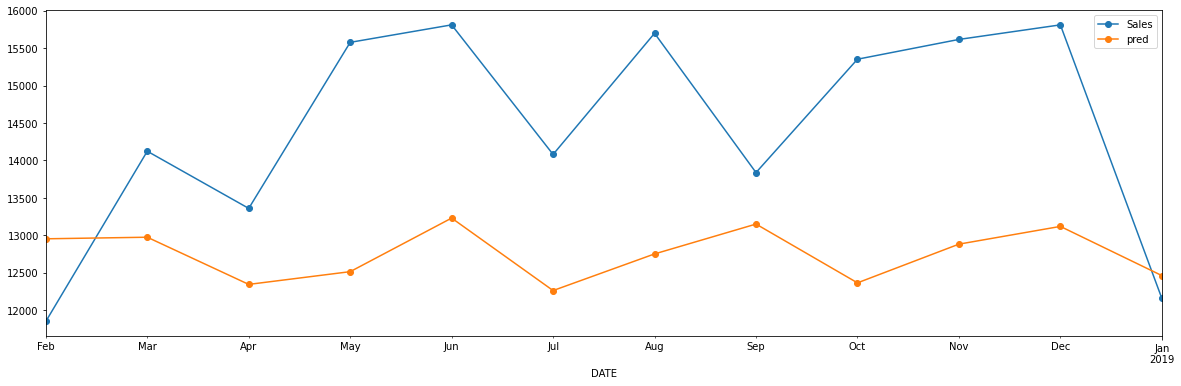

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_x.Sales, order=(3, 2, 3))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Does not get better ! Lets leave it at 3,1,3


---

## 5. SARIMA

If we wish to account for seasonality, the process becomes:-
- first differentiating $(x[i] - x[i-T])$, to remove seasonlity,
- then performing AR and MA,
- then integrating the seasonality back,

This is very tiring.

<br>

Instead of doing so much work to utilise the ARIMA model, we can just apply another model called :the **SARIMA model** directly.

There are 7 parameters for SARIMA: `P,Q,D,p,q,d,s`

We're already familiar with `p, q, d` hyperparameters. Let's take a look at the other parameters.

<br>





### Hyperparamter `s`

> **Q. What does `s` represent and how can we find it's value?**

The parameter `s` represents **seasonality**

- This value we can find using **ACF and PACF plots**.
 - From the ACF and PACF plots of our data, we know that value of `s=12` for this data
 - This is the more sensible approach.
- Alternately, we can treat `s` as a **hyperparameter** and tune to get best value.

![picture](https://drive.google.com/uc?export=view&id=18kLiYsEHyLbx8xWTZFQnZOU6rQHWZOrr)

<br>

In case of lag of order 1, at time t, translates to $y_{t-1}$
> **Q. How is order of `s` translated in Seasonality?**

Lets understand with example.

- For a normal time series, a lag of order of 2 means $y_{t-1}$ and $y_{t-2}$.

 - And this makes sense, as if we're in March 2022, then order of 2 means, lag of 1, i.e. Februray 2022 and lag of 2, i.e. January 2022

- In case of yearly sesaonlity, if we're in March 2022, a lag of order 2, means March 2021, and March 2020.

Therefore, here, an order of m gets translated as:
$y_{t-s}, y_{t-2s}, y_{t-3s}, ..., y_{t-ms}$

- In our business case, this becomes: $y_{t-12}, y_{t-24}, y_{t-36}, ..., y_{t-12m}$

<br>

**Note:-**
- There is one **problem** with SARIMA Model in terms of capturing seasonality.
- **We can only use one value of seasonlity.**



![picture](https://drive.google.com/uc?export=view&id=1psK_dc8ZK9IZt4Ak8gSNsPerF5OsGgU4)



Let's take a look at `P, Q, D`.
- These are similar to `p, q, d` parameters respectively, but they **account for seasonlity components as well**.


### Hyperparameter `P`

Recall the functionality of `p`
- When we set the order of AR as `p`, the formulation becomes: $\hat{y}_t = \alpha_0 + Σ_{i=1}^p α_iy_{t-i}$

<br>

> **The effect of setting `P` hyperparameter for SARIMA is: $Σ_{i=1}^P β_i y_{t-is}$**
 - Since our seasonality is 12
 - Essentially, `P` enables in creating an AR Model on data that is 12 months old, 24 months old, ..., 12P months old: $y_{t-12}, y_{t-24}, ..., y_{t-12P}$
 - So this is exactly like an AutoRegression, but with seasonality.

<br>

Suppose we wish to forecast $\hat{y}_{100}$ (i.e. t=100) with following hyperparameter values:-
- $p = 4$
 - Contribution to final forecast: $α_1 y_{99} + α_2 y_{98} + α_3 y_{97} + α_4 y_{96}$

- $s = 12$

- $P = 3$
 - Contribution to final forecast: $β_1 y_{100-12=88} + β_2 y_{88-12=76} + β_3 y_{76-12=64}$

TODO: Scribble 100

### Hyperparameter `Q`

> **Similarly, the effect of setting `Q` hyperparameter for SARIMA is: $Σ_{i=1}^Q c_i \epsilon_{t-is}$**
 - Since our seasonality is 12
 - Essentially, `Q` enables in creating an MA Model on data that is 12 months old, 24 months old, ..., 12Q months old: $y_{t-12}, y_{t-24}, ..., y_{t-12Q}$
 - So this is exactly like an MovingAverage, but with seasonality.


<br>

Suppose we wish to forecast $\hat{y}_{100}$ with following hyperparameter values:-
- $q = 4$
 - Contribution to final forecast: $m_1 ϵ_{99} + m_2 ϵ_{98} + m_3 ϵ_{97} + m_4 ϵ_{96}$

- $s = 12$

- $Q = 3$
 - Contribution to final forecast: $c_1 ϵ_{100-12=88} + c_2 ϵ_{88-12=76} + c_3 ϵ_{76-12=64}$

TODO: Scribble 101

### Hyperparameter `D`

- Recall that hyperparameter `d` performs differencing on the time series d times, before applying the model.

 - For example if `d=1`: $y_t' = y_t - y_{t-1}$

- Similarly, `D` helps in doing **seasonal differencing** on the time series.
 - For example if `D=1`: $y_t' = y_t - y_{t-s}$
 - Since $s=12$: $y_t' = y_t - y_{t-12}$


![picture](https://drive.google.com/uc?export=view&id=1EFCC4eHLE6E3GKc_19wlSMfWmXniX5KQ)



### SARIMA Summary

![picture](https://drive.google.com/uc?export=view&id=1DiZrD_AP5YemvUlYEKQCp9lfx3myDvQs)

> **Q. How to implement this in code?**

- Besides specifying values for the `order` parameter, we also need to add values for the `seasonal_order` parameter.
- This is done in the order: `P, D, Q, s`

Let's see how the plot looks like

MAE : 539.029
RMSE : 630.333
MAPE: 0.038


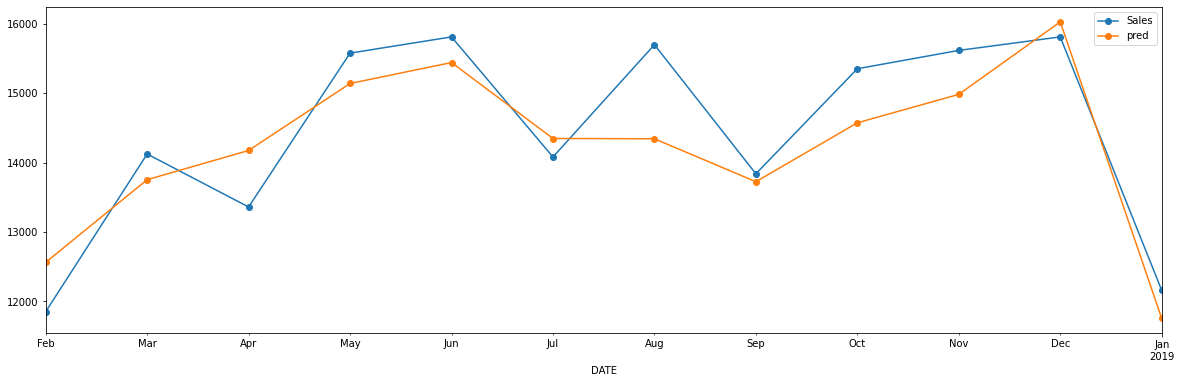

In [ ]:
model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

Great ! This is the best fit so far!! Even better than TES.

---

# End Note

We have seen:
  - Naive Methods (only good for baseline estimates)
  - Smoothing Methods, TES seemed to work great for us.
  - ARIMA methods, SARIMA was the best so far!

Also note that although SARIMA was best but we did not try a lot or different params. It can be hard to find the best combinations of params, and although there are some methods to guess them, they are complex and we wont be didcussing them here.

Hence ARIMA can be great but hard to tune !

---
---